# Explore and visualise synthetic data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing.dag_validation import run_dag_validation_tests, test_residual_independence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from models.train_random_forest import prepare_data, train_random_forest

# Load the data

In [2]:
data_path = '/mnt/RAID/projects/PCS956-Project/data/synthetic_vineyard_data.parquet'

# Check if the data exists
try:
    data = pd.read_parquet(data_path)
    print(f"Data loaded from {data_path}")
except FileNotFoundError:
    print(f"File not found: {data_path}. Please generate the data first.")
    raise

# Show first few rows of data
data.head()

Data loaded from /mnt/RAID/projects/PCS956-Project/data/synthetic_vineyard_data.parquet


,DTM,CHM,NDVI,LAI,Botrytis_Risk
0,75.859246,1.479854,0.672362,0.114011,0.0
1,75.564361,NaN,NaN,NaN,0.0
2,75.966582,NaN,NaN,NaN,0.0
3,75.518372,NaN,NaN,NaN,0.0
4,75.783355,NaN,NaN,NaN,0.0


# Reshape into 2D grid

In [3]:
field_width = 20  # meters
field_length = 200  # meters
resolution = 0.5  # meters per grid cell

grid_width = int(field_width / resolution)  # Number of grid cells in width
grid_length = int(field_length / resolution)  # Number of grid cells in length

# Reshape each column into a 2D grid
DTM = data['DTM'].values.reshape(grid_length, grid_width)
CHM = data['CHM'].values.reshape(grid_length, grid_width)
NDVI = data['NDVI'].values.reshape(grid_length, grid_width)
LAI = data['LAI'].values.reshape(grid_length, grid_width)
Botrytis_Risk = data['Botrytis_Risk'].values.reshape(grid_length, grid_width)

# Visualise 2D grids

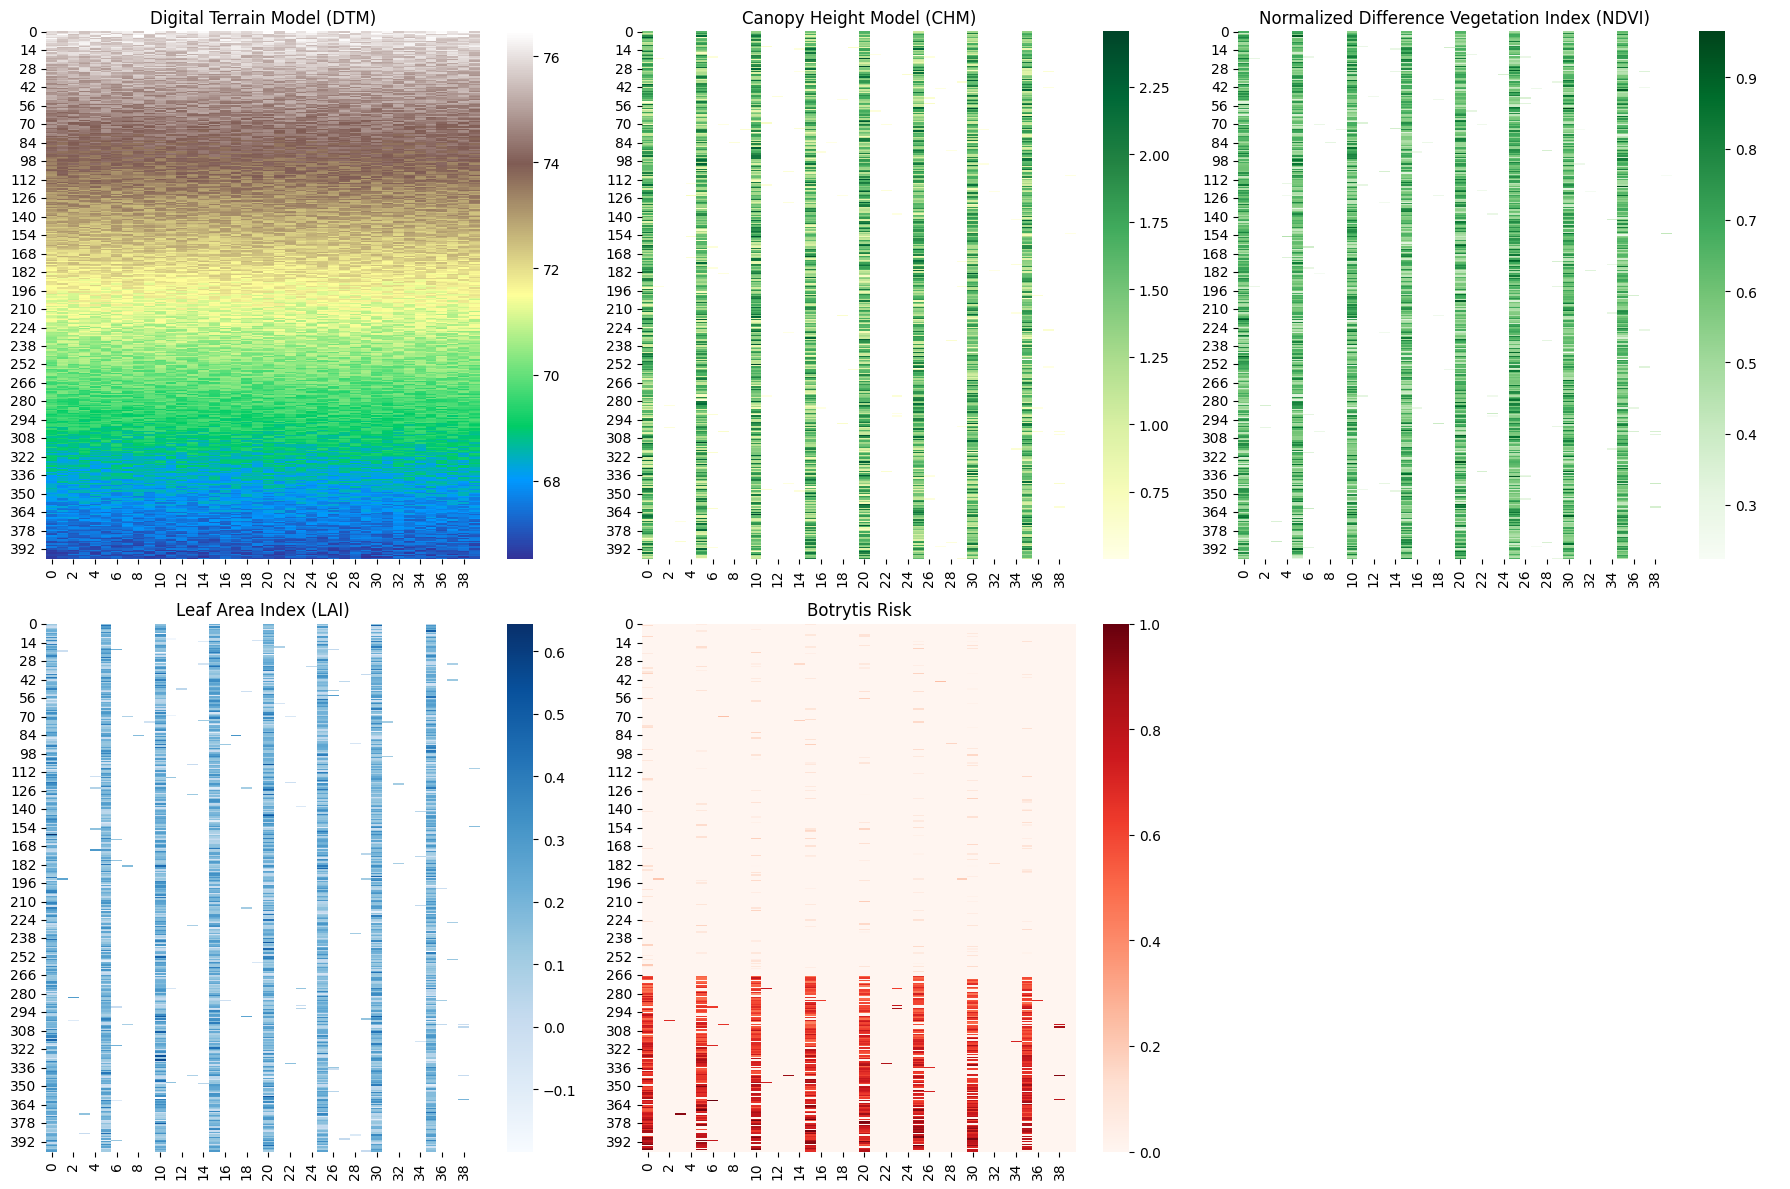

In [4]:
# Set up the figure size for better clarity
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot Digital Terrain Model (DTM)
sns.heatmap(DTM, ax=axes[0, 0], cmap='terrain', annot=False)
axes[0, 0].set_title('Digital Terrain Model (DTM)')

# Plot Canopy Height Model (CHM)
sns.heatmap(CHM, ax=axes[0, 1], cmap='YlGn', annot=False)
axes[0, 1].set_title('Canopy Height Model (CHM)')

# Plot Normalized Difference Vegetation Index (NDVI)
sns.heatmap(NDVI, ax=axes[0, 2], cmap='Greens', annot=False)
axes[0, 2].set_title('Normalized Difference Vegetation Index (NDVI)')

# Plot Leaf Area Index (LAI)
sns.heatmap(LAI, ax=axes[1, 0], cmap='Blues', annot=False)
axes[1, 0].set_title('Leaf Area Index (LAI)')

# Plot Botrytis Risk
sns.heatmap(Botrytis_Risk, ax=axes[1, 1], cmap='Reds', annot=False)
axes[1, 1].set_title('Botrytis Risk')

# Leave the last plot empty for spacing
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Dependency Check with Residual Independence Tests

## Test 1: DTM and Botrytis Risk conditional on CHM and LAI


Testing DTM and Botrytis Risk conditional on CHM and LAI:


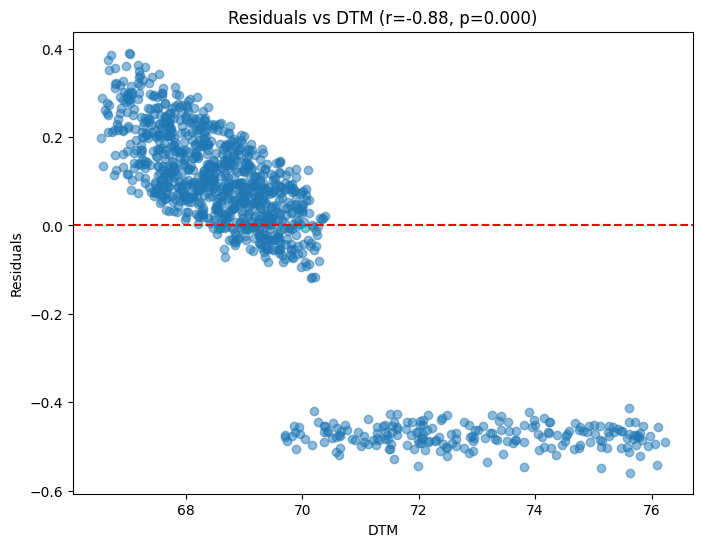

Result: {'correlation_coefficient': np.float64(-0.8804940909667638), 'p_value': np.float64(0.0)}


In [5]:
# Set a threshold for Botrytis Risk
risk_threshold = 0

# Filter the data to include only rows where Botrytis Risk is above the threshold
filtered_data = data[data['Botrytis_Risk'] > risk_threshold]

# Prepare the features and target for the test
X = filtered_data[['CHM', 'LAI']]
y = filtered_data['Botrytis_Risk']
conditioning_var = filtered_data['DTM']

# Run the test for conditional independence
print("\nTesting DTM and Botrytis Risk conditional on CHM and LAI:")
test_result = test_residual_independence(X, y, conditioning_var)
print(f"Result: {test_result}")


Testing CHM and NDVI direct dependence:


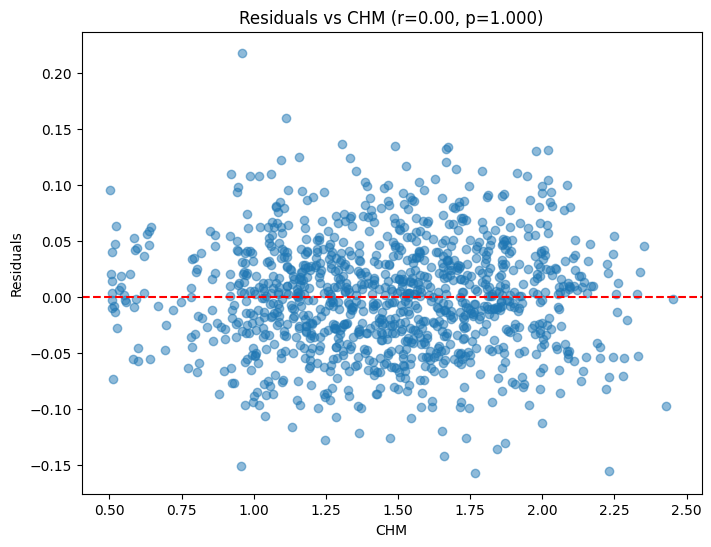

Result: {'correlation_coefficient': np.float64(5.342948306008566e-16), 'p_value': np.float64(0.9999999999999882)}


In [6]:
X = filtered_data[['CHM']]
y = filtered_data['NDVI']
conditioning_var = filtered_data['CHM']
print("\nTesting CHM and NDVI direct dependence:")
test_result_2 = test_residual_independence(X, y, conditioning_var)
print(f"Result: {test_result_2}")


Testing LAI and NDVI conditional on Botrytis Risk:


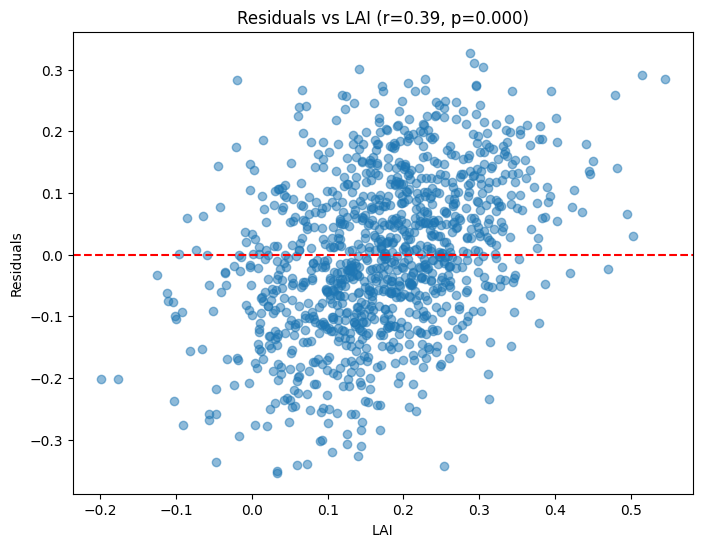

Result: {'correlation_coefficient': np.float64(0.3904942934803057), 'p_value': np.float64(2.379995338982311e-41)}


In [7]:
# Test 3: LAI and NDVI conditional on Botrytis Risk
X = filtered_data[['Botrytis_Risk']]
y = filtered_data['NDVI']
conditioning_var = filtered_data['LAI']
print("\nTesting LAI and NDVI conditional on Botrytis Risk:")
test_result_3 = test_residual_independence(X, y, conditioning_var)
print(f"Result: {test_result_3}")


Testing DTM and NDVI conditional on CHM:


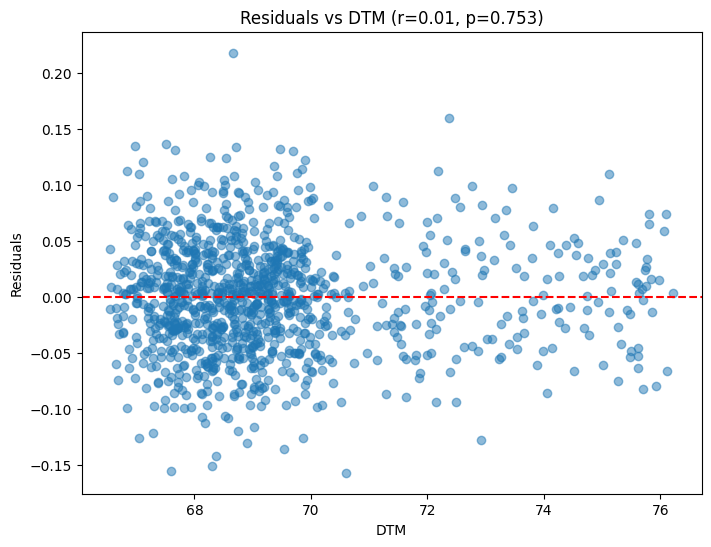

Result: {'correlation_coefficient': np.float64(0.009510511357859939), 'p_value': np.float64(0.752812601990853)}


In [8]:
X = filtered_data[['CHM']]
y = filtered_data['NDVI']
conditioning_var = filtered_data['DTM']
print("\nTesting DTM and NDVI conditional on CHM:")
test_result_4 = test_residual_independence(X, y, conditioning_var)
print(f"Result: {test_result_4}")

# Train Classifier

## Load Data

Accuracy: 0.9195751138088012
Classification Report:
              precision    recall  f1-score     support
0              0.978678  0.914343  0.945417  502.000000
1              0.773684  0.936306  0.847262  157.000000
accuracy       0.919575  0.919575  0.919575    0.919575
macro avg      0.876181  0.925324  0.896340  659.000000
weighted avg   0.929840  0.919575  0.922033  659.000000
Feature Importances:
  feature  importance
0     DTM        0.56
1     CHM        0.18
2    NDVI        0.18
3     LAI        0.08


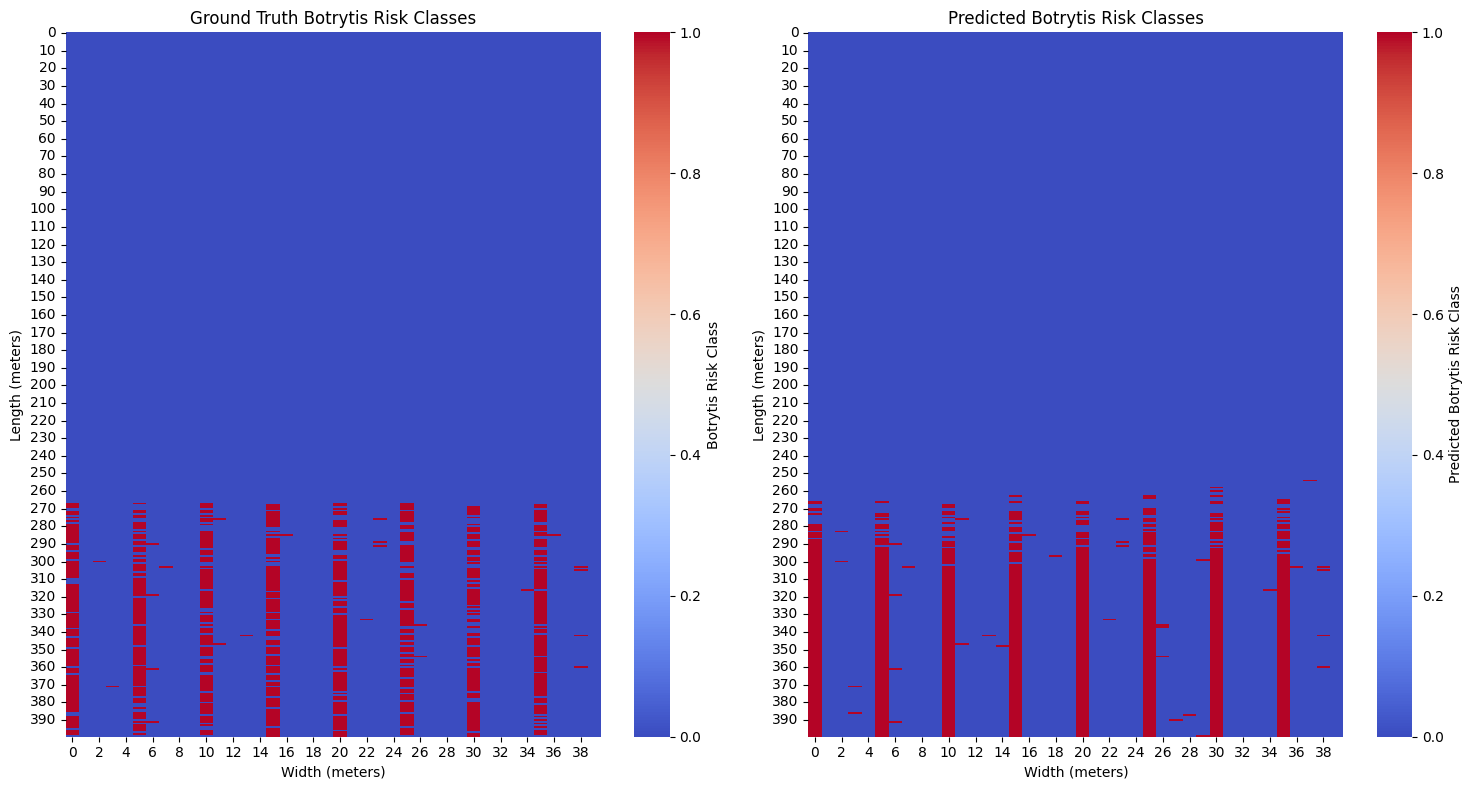

In [9]:
# Load and prepare data
data_path = '/mnt/RAID/projects/PCS956-Project/data/synthetic_vineyard_data.parquet'
data = pd.read_parquet(data_path)

# Prepare features, target variable, NaN mask, and full data
X, y, nan_mask, full_data = prepare_data(data, risk_threshold=0.5)

# Train Random Forest model
metrics, feature_importance_df, rf_model = train_random_forest(X, y, max_depth=1)

# Display metrics and feature importances
print("Accuracy:", metrics['accuracy'])
print("Classification Report:")
print(pd.DataFrame(metrics['classification_report']).transpose())
print("Feature Importances:")
print(feature_importance_df)

# Predict on the prepared data
y_pred = rf_model.predict(X)

# Reshape predictions and ground truth to the original 2D grid dimensions for visualization
field_width = 20  # meters
field_length = 200  # meters
resolution = 0.5  # meters per grid cell

grid_width = int(field_width / resolution)
grid_length = int(field_length / resolution)

# Create binary classification grid based on the threshold
Botrytis_Risk_Class = (data['Botrytis_Risk'] > 0.5).astype(int)  # Ground truth for Botrytis Risk Class
y_pred_full = np.full(Botrytis_Risk_Class.shape, np.nan)  # Placeholder for predictions

# Map the predictions back to the full grid, excluding NaN locations
y_pred_full[~nan_mask] = y_pred

# Reshape ground truth and predictions, applying NaN mask
Botrytis_Risk_Class_grid = Botrytis_Risk_Class.values.reshape(grid_length, grid_width)
Predicted_Class_grid = y_pred_full.reshape(grid_length, grid_width)
Predicted_Class_grid = np.nan_to_num(Predicted_Class_grid)

# Plot the ground truth and predicted classifications side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the ground truth
sns.heatmap(Botrytis_Risk_Class_grid, ax=axes[0], cmap='coolwarm', cbar=True, cbar_kws={'label': 'Botrytis Risk Class'})
axes[0].set_title('Ground Truth Botrytis Risk Classes')
axes[0].set_xlabel('Width (meters)')
axes[0].set_ylabel('Length (meters)')

# Plot the predicted classifications
sns.heatmap(Predicted_Class_grid, ax=axes[1], cmap='coolwarm', cbar=True, cbar_kws={'label': 'Predicted Botrytis Risk Class'})
axes[1].set_title('Predicted Botrytis Risk Classes')
axes[1].set_xlabel('Width (meters)')
axes[1].set_ylabel('Length (meters)')

plt.tight_layout()
plt.show()

# KDE

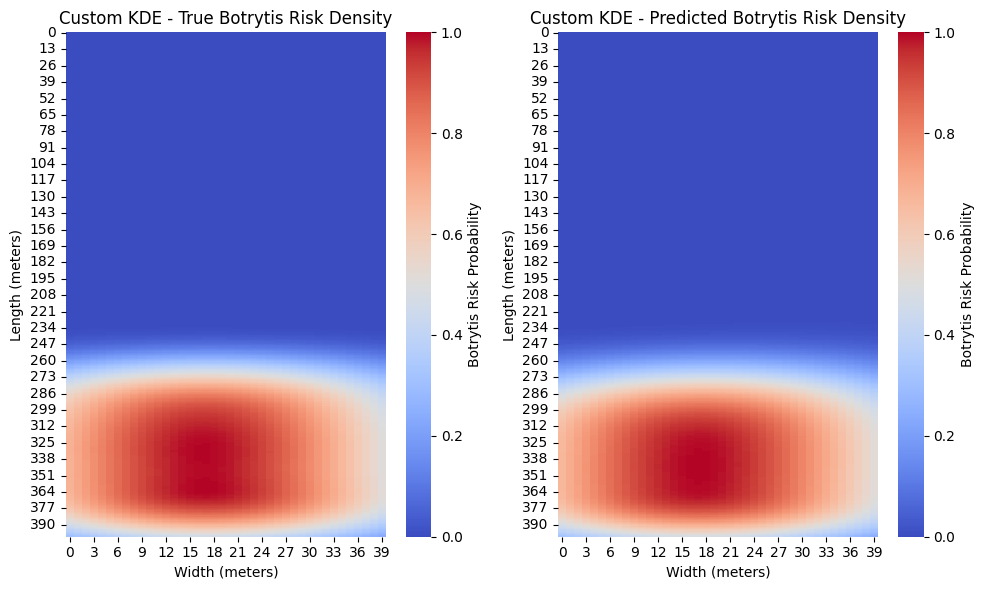

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree

# Define the biweight (quartic) kernel function
def biweight_kernel(distances, bandwidth):
    u = distances / bandwidth
    weights = np.where(u < 1, (15 / 16) * (1 - u**2)**2, 0)
    return weights

# 2D KDE using a custom kernel
def custom_kde2D(x, y, bandwidth, grid_width, grid_length, resolution, kernel_func):
    """Perform 2D KDE using a custom kernel over grid dimensions and resolution."""
    # Define grid for the KDE
    x_grid = np.linspace(0, field_width, grid_width)
    y_grid = np.linspace(0, field_length, grid_length)
    xx, yy = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Prepare sample points for KDE
    sample_points = np.vstack([x, y]).T
    
    # Build KD-Tree for sample points
    tree = cKDTree(sample_points)
    
    # Query distances to all sample points within bandwidth for each grid point
    distances, _ = tree.query(grid_points, k=len(sample_points), distance_upper_bound=bandwidth)
    
    # Apply custom kernel to distances
    density_values = kernel_func(distances, bandwidth).sum(axis=1)
    
    # Reshape density values to grid and normalize for visualization
    density_grid = density_values.reshape(grid_length, grid_width)
    density_normalized = (density_grid - density_grid.min()) / (density_grid.max() - density_grid.min())
    
    return density_normalized

# Example parameters for grid and data (using actual Botrytis data for true/predicted KDE)
field_width, field_length, resolution = 20, 200, 0.5
grid_width = int(field_width / resolution)
grid_length = int(field_length / resolution)
bandwidth = 19.68

# Assume Botrytis_Risk_Class_grid and Predicted_Class_grid are defined binary grids (0/1)
# Extract presence points from these grids for KDE

# For the true presence points
y_indices_true, x_indices_true = np.where(Botrytis_Risk_Class_grid == 1)
presence_points_true = np.column_stack((x_indices_true * resolution, y_indices_true * resolution))

# For the predicted presence points
y_indices_pred, x_indices_pred = np.where(Predicted_Class_grid == 1)
presence_points_pred = np.column_stack((x_indices_pred * resolution, y_indices_pred * resolution))

# Run custom KDE with biweight kernel on true presence points
density_true_custom = custom_kde2D(
    presence_points_true[:, 0], 
    presence_points_true[:, 1], 
    bandwidth, grid_width, grid_length, resolution, biweight_kernel
)

# Run custom KDE with biweight kernel on predicted presence points
density_pred_custom = custom_kde2D(
    presence_points_pred[:, 0], 
    presence_points_pred[:, 1], 
    bandwidth, grid_width, grid_length, resolution, biweight_kernel
)

# Plotting KDE density heatmaps for true and predicted with custom kernel
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# KDE for True Presence Points with Custom Kernel
sns.heatmap(density_true_custom, ax=axes[0], cmap='coolwarm', cbar=True, cbar_kws={'label': 'Botrytis Risk Probability'})
axes[0].set_title("Custom KDE - True Botrytis Risk Density")
axes[0].set_xlabel("Width (meters)")
axes[0].set_ylabel("Length (meters)")

# KDE for Predicted Presence Points with Custom Kernel
sns.heatmap(density_pred_custom, ax=axes[1], cmap='coolwarm', cbar=True, cbar_kws={'label': 'Botrytis Risk Probability'})
axes[1].set_title("Custom KDE - Predicted Botrytis Risk Density")
axes[1].set_xlabel("Width (meters)")
axes[1].set_ylabel("Length (meters)")

plt.tight_layout()
plt.show()


# KAN

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from models.kan import KAN  # Ensure KAN model is imported

# Custom KAN Model with Batch Normalization and Dropout
class ExtendedKAN(KAN):
    def __init__(self, layers_hidden, grid_size=5, spline_order=2, dropout=0.2):
        super(ExtendedKAN, self).__init__(layers_hidden, grid_size, spline_order)
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        in_features = layers_hidden[0]
        
        # Define layers, including BatchNorm and dropout
        for out_features in layers_hidden[1:]:
            self.layers.append(nn.Linear(in_features, out_features))
            self.batch_norms.append(nn.BatchNorm1d(out_features))
            in_features = out_features
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for layer, batch_norm in zip(self.layers, self.batch_norms):
            x = batch_norm(layer(x))
            x = self.dropout(x)
        return x

## Instantiate model and train

In [12]:
# Instantiate model
model = ExtendedKAN([4, 16, 1], grid_size=5, spline_order=1, dropout=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# %% [markdown]
# # Dataset Preparation for KAN Model

# %%
def prepare_data(data, risk_threshold=0.5):
    data['Botrytis_Risk_Class'] = (data['Botrytis_Risk'] > risk_threshold).astype(int)
    filtered_data = data.dropna(subset=['DTM', 'CHM', 'NDVI', 'LAI', 'Botrytis_Risk'])
    X = filtered_data[['DTM', 'CHM', 'NDVI', 'LAI']].values
    y = filtered_data['Botrytis_Risk_Class'].values
    return X, y

X, y = prepare_data(data)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Weighted Sampling for Class Imbalance
class_counts = np.bincount(y_train)
weights = 1.0 / class_counts
sample_weights = weights[y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
trainloader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define loss with positional weight
pos_weight = torch.tensor([len(y) / np.bincount(y)[1]], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# %% [markdown]
# # Training Loop for KAN Model

# %%
epochs = 20
for epoch in range(epochs):
    model.train()
    with tqdm(trainloader) as pbar:
        for features, labels in pbar:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            accuracy = (torch.sigmoid(output).round() == labels).float().mean()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    # Validation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for features, labels in valloader:
            features, labels = features.to(device), labels.to(device)
            output = model(features)
            val_loss += criterion(output, labels).item()
            predictions = torch.sigmoid(output).round()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_accuracy += (predictions == labels).float().mean().item()
    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    scheduler.step()

    # Print Distribution
    unique, counts = np.unique(all_predictions, return_counts=True)
    print(f"Prediction distribution: {dict(zip(unique, counts))}")
    unique_labels, label_counts = np.unique(all_labels, return_counts=True)
    print(f"Label distribution in validation: {dict(zip(unique_labels, label_counts))}")
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

100%|██████████| 83/83 [00:01<00:00, 54.80it/s, accuracy=0.875, loss=0.767, lr=0.0005]


Prediction distribution: {np.float32(0.0): np.int64(410), np.float32(1.0): np.int64(249)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 1/20, Val Loss: 0.7500, Val Accuracy: 0.8729


100%|██████████| 83/83 [00:00<00:00, 87.52it/s, accuracy=0.625, loss=2.09, lr=0.000488]  


Prediction distribution: {np.float32(0.0): np.int64(398), np.float32(1.0): np.int64(261)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 2/20, Val Loss: 0.7400, Val Accuracy: 0.8587


100%|██████████| 83/83 [00:00<00:00, 87.77it/s, accuracy=1, loss=0.83, lr=0.000452]     


Prediction distribution: {np.float32(0.0): np.int64(379), np.float32(1.0): np.int64(280)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 3/20, Val Loss: 0.7081, Val Accuracy: 0.8317


100%|██████████| 83/83 [00:00<00:00, 104.58it/s, accuracy=0.75, loss=1.5, lr=0.000397]   


Prediction distribution: {np.float32(0.0): np.int64(378), np.float32(1.0): np.int64(281)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 4/20, Val Loss: 0.6959, Val Accuracy: 0.8303


100%|██████████| 83/83 [00:00<00:00, 107.17it/s, accuracy=0.875, loss=0.75, lr=0.000327] 


Prediction distribution: {np.float32(0.0): np.int64(358), np.float32(1.0): np.int64(301)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 5/20, Val Loss: 0.7086, Val Accuracy: 0.7985


100%|██████████| 83/83 [00:00<00:00, 106.04it/s, accuracy=0.875, loss=0.962, lr=0.00025]


Prediction distribution: {np.float32(0.0): np.int64(362), np.float32(1.0): np.int64(297)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 6/20, Val Loss: 0.7068, Val Accuracy: 0.8042


100%|██████████| 83/83 [00:00<00:00, 102.42it/s, accuracy=0.75, loss=1.12, lr=0.000173]  


Prediction distribution: {np.float32(0.0): np.int64(364), np.float32(1.0): np.int64(295)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 7/20, Val Loss: 0.6887, Val Accuracy: 0.8070


100%|██████████| 83/83 [00:00<00:00, 110.70it/s, accuracy=0.875, loss=0.904, lr=0.000103]


Prediction distribution: {np.float32(0.0): np.int64(364), np.float32(1.0): np.int64(295)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 8/20, Val Loss: 0.6871, Val Accuracy: 0.8070


100%|██████████| 83/83 [00:00<00:00, 112.95it/s, accuracy=0.75, loss=0.674, lr=4.77e-5] 


Prediction distribution: {np.float32(0.0): np.int64(333), np.float32(1.0): np.int64(326)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 9/20, Val Loss: 0.7107, Val Accuracy: 0.7630


100%|██████████| 83/83 [00:00<00:00, 114.27it/s, accuracy=0.75, loss=0.768, lr=1.22e-5] 


Prediction distribution: {np.float32(0.0): np.int64(357), np.float32(1.0): np.int64(302)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 10/20, Val Loss: 0.6887, Val Accuracy: 0.7971


100%|██████████| 83/83 [00:00<00:00, 112.17it/s, accuracy=0.75, loss=0.964, lr=0] 


Prediction distribution: {np.float32(0.0): np.int64(358), np.float32(1.0): np.int64(301)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 11/20, Val Loss: 0.7012, Val Accuracy: 0.7985


100%|██████████| 83/83 [00:00<00:00, 115.01it/s, accuracy=0.875, loss=1.01, lr=1.22e-5] 


Prediction distribution: {np.float32(0.0): np.int64(362), np.float32(1.0): np.int64(297)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 12/20, Val Loss: 0.6969, Val Accuracy: 0.8042


100%|██████████| 83/83 [00:00<00:00, 114.69it/s, accuracy=0.875, loss=1.26, lr=4.77e-5] 


Prediction distribution: {np.float32(0.0): np.int64(359), np.float32(1.0): np.int64(300)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 13/20, Val Loss: 0.6981, Val Accuracy: 0.7999


100%|██████████| 83/83 [00:00<00:00, 114.09it/s, accuracy=0.625, loss=0.782, lr=0.000103]


Prediction distribution: {np.float32(0.0): np.int64(358), np.float32(1.0): np.int64(301)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 14/20, Val Loss: 0.6855, Val Accuracy: 0.7985


100%|██████████| 83/83 [00:00<00:00, 113.08it/s, accuracy=0.75, loss=0.548, lr=0.000173] 


Prediction distribution: {np.float32(0.0): np.int64(359), np.float32(1.0): np.int64(300)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 15/20, Val Loss: 0.6815, Val Accuracy: 0.7999


100%|██████████| 83/83 [00:00<00:00, 115.82it/s, accuracy=0.75, loss=1.13, lr=0.00025]  


Prediction distribution: {np.float32(0.0): np.int64(357), np.float32(1.0): np.int64(302)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 16/20, Val Loss: 0.6909, Val Accuracy: 0.7971


100%|██████████| 83/83 [00:00<00:00, 114.03it/s, accuracy=1, loss=0.762, lr=0.000327]    


Prediction distribution: {np.float32(0.0): np.int64(346), np.float32(1.0): np.int64(313)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 17/20, Val Loss: 0.6931, Val Accuracy: 0.7815


100%|██████████| 83/83 [00:00<00:00, 112.93it/s, accuracy=0.875, loss=1.15, lr=0.000397] 


Prediction distribution: {np.float32(0.0): np.int64(357), np.float32(1.0): np.int64(302)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 18/20, Val Loss: 0.6826, Val Accuracy: 0.7971


100%|██████████| 83/83 [00:00<00:00, 111.93it/s, accuracy=0.75, loss=1.13, lr=0.000452]  


Prediction distribution: {np.float32(0.0): np.int64(350), np.float32(1.0): np.int64(309)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 19/20, Val Loss: 0.6664, Val Accuracy: 0.7872


100%|██████████| 83/83 [00:00<00:00, 113.57it/s, accuracy=1, loss=0.46, lr=0.000488]     


Prediction distribution: {np.float32(0.0): np.int64(347), np.float32(1.0): np.int64(312)}
Label distribution in validation: {np.float32(0.0): np.int64(488), np.float32(1.0): np.int64(171)}
Epoch 20/20, Val Loss: 0.6641, Val Accuracy: 0.7829


# Visualise

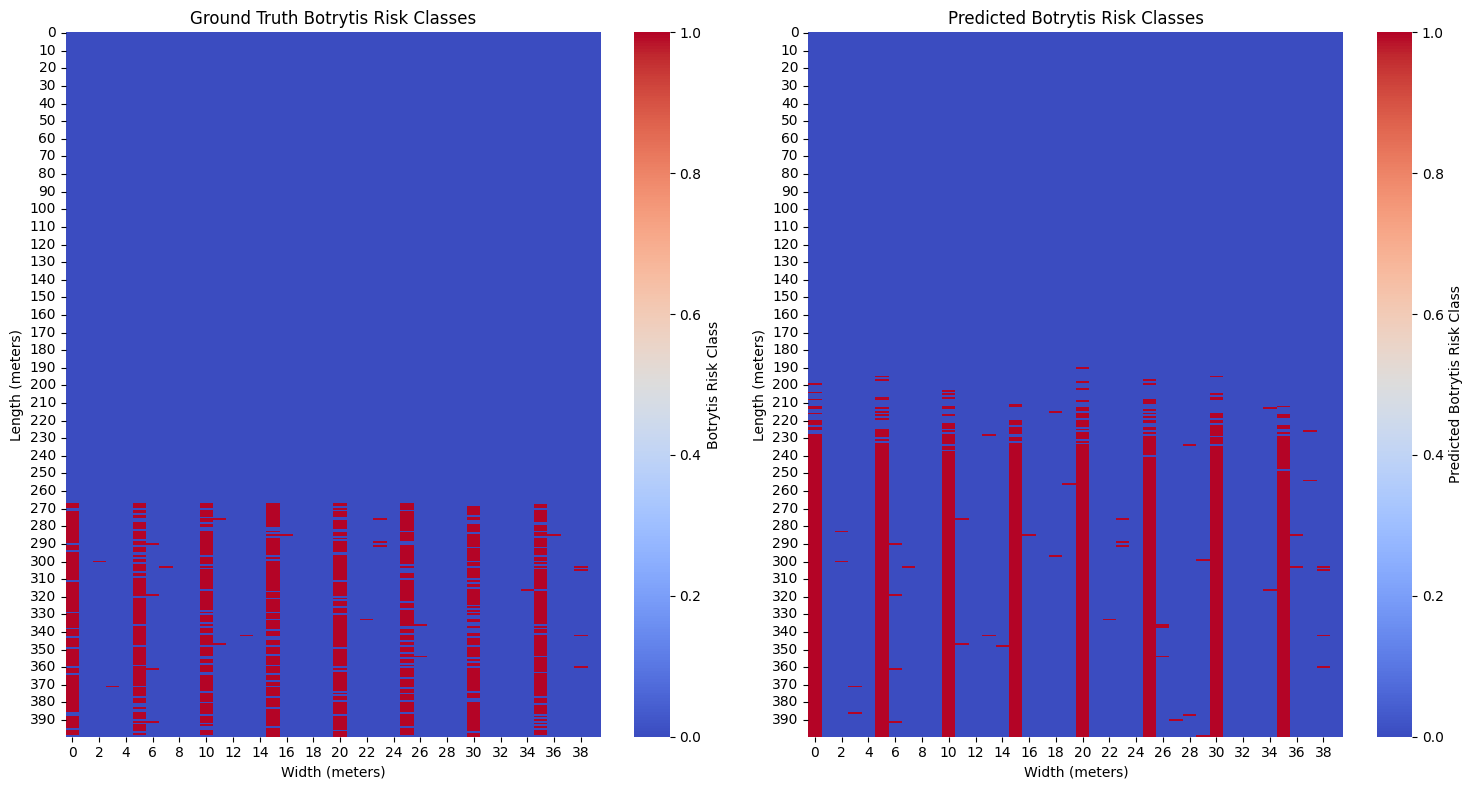

In [13]:
# Reshape predictions and ground truth to the original 2D grid dimensions for visualization
grid_width = int(field_width / resolution)
grid_length = int(field_length / resolution)

# Create binary classification grid based on the threshold
Botrytis_Risk_Class = (data['Botrytis_Risk'] > 0.3).astype(int)  # Ground truth for Botrytis Risk Class
y_pred_full = np.full(Botrytis_Risk_Class.shape, np.nan)  # Placeholder for predictions

# Map the KAN model predictions back to the full grid, excluding NaN locations
model.eval()  # Set model to evaluation mode

with torch.no_grad():
    features_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    output = model(features_tensor)
    predictions = torch.sigmoid(output).cpu().round().numpy().flatten()

# Update predictions for non-NaN values in the full grid
y_pred_full[~nan_mask] = predictions

# Reshape ground truth and predictions to 2D grids
Botrytis_Risk_Class_grid = Botrytis_Risk_Class.values.reshape(grid_length, grid_width)
Predicted_Class_grid = y_pred_full.reshape(grid_length, grid_width)
Predicted_Class_grid = np.nan_to_num(Predicted_Class_grid)  # Replace NaNs with 0s

# Plot the ground truth and predicted classifications side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the ground truth
sns.heatmap(Botrytis_Risk_Class_grid, ax=axes[0], cmap='coolwarm', cbar=True, cbar_kws={'label': 'Botrytis Risk Class'})
axes[0].set_title('Ground Truth Botrytis Risk Classes')
axes[0].set_xlabel('Width (meters)')
axes[0].set_ylabel('Length (meters)')

# Plot the predicted classifications
sns.heatmap(Predicted_Class_grid, ax=axes[1], cmap='coolwarm', cbar=True, cbar_kws={'label': 'Predicted Botrytis Risk Class'})
axes[1].set_title('Predicted Botrytis Risk Classes')
axes[1].set_xlabel('Width (meters)')
axes[1].set_ylabel('Length (meters)')

plt.tight_layout()
plt.show()